Aim: Write a program to Generate MNIST Digits using GANs.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
train = pd.read_csv('mnist_train_small.csv', header=None)

In [3]:
train.shape

(20000, 785)

In [4]:
epochs = 150
batch_size = 256

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [6]:
X_train = train.values[:, 1:]
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_train /= 255.0

In [7]:
X_train.shape

torch.Size([20000, 784])

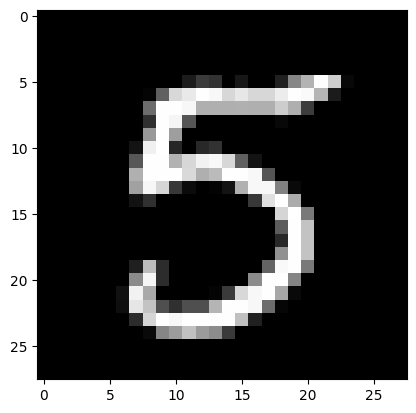

In [8]:
plt.imshow(X_train[1].cpu().numpy().reshape(28, 28), cmap="gray")

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(100, 256)
        self.l2 = nn.Linear(256, 512)
        self.l3 = nn.Linear(512, 1024)
        self.l4 = nn.Linear(1024, 28 * 28)

        self.relu = nn.PReLU(1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))
        return self.tanh(self.l4(x))

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28 * 28, 1024)
        self.l2 = nn.Linear(1024, 512)
        self.l3 = nn.Linear(512, 256)
        self.l4 = nn.Linear(256, 1)

        self.leaky = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky(self.l1(x))
        x = self.dropout(x)
        x = self.leaky(self.l2(x))
        x = self.dropout(x)
        x = self.leaky(self.l3(x))
        x = self.dropout(x)
        return self.sigmoid(self.l4(x))

In [11]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (l1): Linear(in_features=100, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=512, bias=True)
  (l3): Linear(in_features=512, out_features=1024, bias=True)
  (l4): Linear(in_features=1024, out_features=784, bias=True)
  (relu): PReLU(num_parameters=1)
  (tanh): Tanh()
)
Discriminator(
  (l1): Linear(in_features=784, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=512, bias=True)
  (l3): Linear(in_features=512, out_features=256, bias=True)
  (l4): Linear(in_features=256, out_features=1, bias=True)
  (leaky): LeakyReLU(negative_slope=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)


In [12]:
criteria = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
d_loss_history = []
g_loss_history = []
ep_history = []

steps = len(X_train)
for e in range(epochs):
    for i in range(0, steps, batch_size):
        x_batch = X_train[i:i+batch_size]

        real_labels = torch.ones(x_batch.size(0), 1).to(device)
        fake_labels = torch.zeros(x_batch.size(0), 1).to(device)

        optimizer_D.zero_grad()
        real_loss = criteria(discriminator(x_batch), real_labels)

        z = torch.randn(x_batch.size(0), 100).to(device)
        fake_imgs = generator(z)

        fake_loss = criteria(discriminator(fake_imgs.detach()), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        g_loss = criteria(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

    d_loss_history.append(d_loss.item())
    g_loss_history.append(g_loss.item())
    ep_history.append(e)

    print(f"Epoch {e+1}/{epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

Epoch 1/150, D Loss: 1.2324, G Loss: 0.8995
Epoch 2/150, D Loss: 0.4813, G Loss: 3.0976
Epoch 3/150, D Loss: 1.2892, G Loss: 4.0070
Epoch 4/150, D Loss: 0.8669, G Loss: 3.3578
Epoch 5/150, D Loss: 0.6179, G Loss: 4.5297
Epoch 6/150, D Loss: 0.7194, G Loss: 3.9879
Epoch 7/150, D Loss: 0.8479, G Loss: 3.4886
Epoch 8/150, D Loss: 0.5871, G Loss: 3.6990
Epoch 9/150, D Loss: 0.5570, G Loss: 2.8730
Epoch 10/150, D Loss: 0.6448, G Loss: 4.2158
Epoch 11/150, D Loss: 0.6703, G Loss: 3.7944
Epoch 12/150, D Loss: 0.5215, G Loss: 2.6264
Epoch 13/150, D Loss: 0.8852, G Loss: 3.8326
Epoch 14/150, D Loss: 0.7948, G Loss: 3.8570
Epoch 15/150, D Loss: 0.6090, G Loss: 3.8569
Epoch 16/150, D Loss: 0.4149, G Loss: 3.5229
Epoch 17/150, D Loss: 0.4972, G Loss: 3.6765
Epoch 18/150, D Loss: 0.4705, G Loss: 2.8589
Epoch 19/150, D Loss: 0.5266, G Loss: 3.6304
Epoch 20/150, D Loss: 0.6104, G Loss: 5.1176
Epoch 21/150, D Loss: 0.7083, G Loss: 5.1819
Epoch 22/150, D Loss: 0.5614, G Loss: 3.6251
Epoch 23/150, D Los

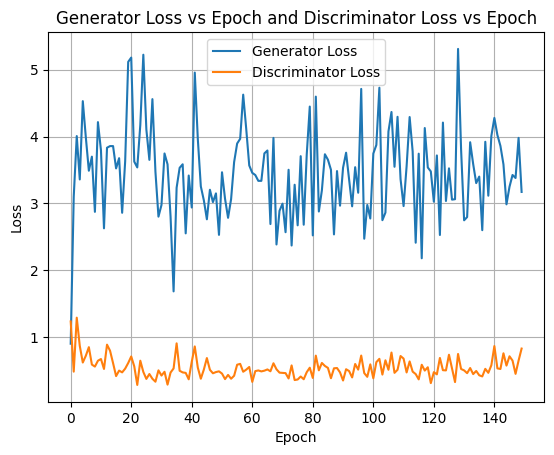

In [14]:
fg = plt.figure()
plt.plot(ep_history, g_loss_history)
plt.plot(ep_history, d_loss_history)
plt.legend(["Generator Loss", "Discriminator Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss vs Epoch and Discriminator Loss vs Epoch")
plt.grid()
plt.show()

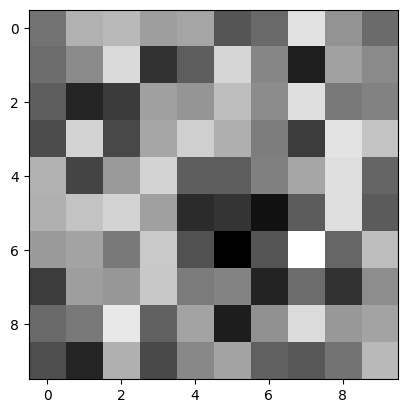

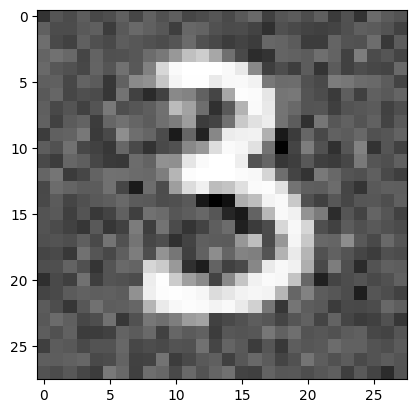

In [15]:
with torch.no_grad():
    sample = torch.randn(1, 100).to(device)
    output = generator(sample)
    plt.imshow(sample.cpu().reshape(10, 10), cmap='gray')
    plt.show()
    plt.imshow(output.cpu().reshape(28, 28), cmap='gray')
    plt.show()